# 📊 Toxic Comment Classification: Data Preprocessing & Exploratory Analysis

This notebook focuses on **exploratory data analysis (EDA)** and **preprocessing** for the **Toxic Comment Classification** task. It prepares the dataset for future machine learning or deep learning modeling.

---

## 🗂️ Key Components

### 1. Data Loading
- Loads the dataset `comments.csv`, which contains user comments along with multiple binary labels indicating types of toxicity.

---

### 2. Labeling Clean Comments
- Introduces a new **"clean"** label for comments that have **no toxic tags**.

#### Summary Statistics:
- **Total comments**
- **Number of clean comments**
- **Total toxic tags across all comments**

---

### 3. Class Imbalance Analysis
- Observes that **only ~10%** of the comments are labeled as toxic.
- Highlights **class imbalance** as a key challenge in building effective classifiers.

---

### 4. Co-occurrence of Toxic Tags
- Explores how different toxic labels co-occur using **correlation heatmaps**.
- Notes limitations of using **Pearson correlation** with binary data.
- Suggests better alternatives:
  - **Cramér’s V statistic**
  - **Confusion matrices**

---

### 5. Visualizations

#### Label Frequencies:
- Bar plots showing the distribution of each toxic label.

#### Word Clouds:
- **Clean comments**
- **Toxic comments**

These visualizations help in understanding the most frequently occurring terms across different comment types.

---

## Libraries Used

- `pandas`, `numpy` – data handling
- `matplotlib`, `seaborn` – plotting and visualization
- `wordcloud` – for generating word clouds
- `nltk` – tokenization and lemmatization

---

> ✅ This notebook forms a solid foundation for feature engineering and model development in the toxic comment classification pipeline.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import re
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   
from nltk.corpus import stopwords

tokenizer=TweetTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))



### Feching the data ###

In [2]:
comments_df = pd.read_csv("/Users/anugrahrastogi21gmail.com/Downloads/comments.csv")
comments_df.shape

(159571, 8)

In [3]:
# take a peak
comments_df.tail(10)

id                                       comment_text  \
159561  ffd2e85b07b3c7e4  "\nNo he did not, read it again (I would have ...   
159562  ffd72e9766c09c97  "\n Auto guides and the motoring press are not...   
159563  ffe029a7c79dc7fe  "\nplease identify what part of BLP applies be...   
159564  ffe897e7f7182c90  Catalan independentism is the social movement ...   
159565  ffe8b9316245be30  The numbers in parentheses are the additional ...   
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        toxic  severe_toxic  obscene  threat  insult  identity_hate  
159561      0             0        0       0       0              0  
159562      0             0        0       0       0              0  
159563      0             0        0       0       0              0  
159564      0             0        0       0       0              0  
159565      0             0        0       0       0              0  
159566      0             0        0       0       0              0  
159567      0             0        0       0       0              0  
159568      0             0        0       0       0              0  
159569      0             0        0       0       0              0  
159570      0             0        0       0       0              0

### EDA(exploratory data analysis) ###

In [4]:
x=comments_df.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=comments_df.iloc[:,2:].sum(axis=1)
comments_df['clean']=(rowsums==0)
#count number of clean entries
comments_df['clean'].sum()
print("Total comments = ",len(comments_df))
print("Total clean comments = ",comments_df['clean'].sum())
print("Total tags =",x.sum())

Total comments =  159571
Total clean comments =  143346
Total tags = 35098


#### Check for any 'null' comment ####


In [5]:
print("Check for missing values in dataset")
null_check=comments_df.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")
comments_df["comment_text"].fillna("unknown", inplace=True)

Check for missing values in dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
filling NA with "unknown"


/var/folders/2n/0w23czwn2mjd3pg0c15vjyz80000gn/T/ipykernel_12351/808639257.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  comments_df["comment_text"].fillna("unknown", inplace=True)


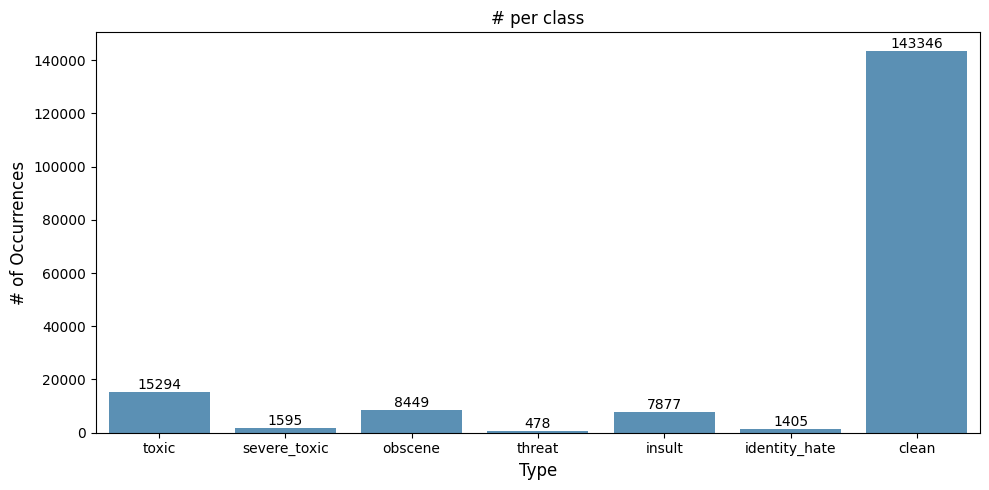

In [6]:
x = comments_df.iloc[:, 2:].sum()

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type', fontsize=12)

# Adding the text labels
for rect, label in zip(ax.patches, x.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(label),
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems ###

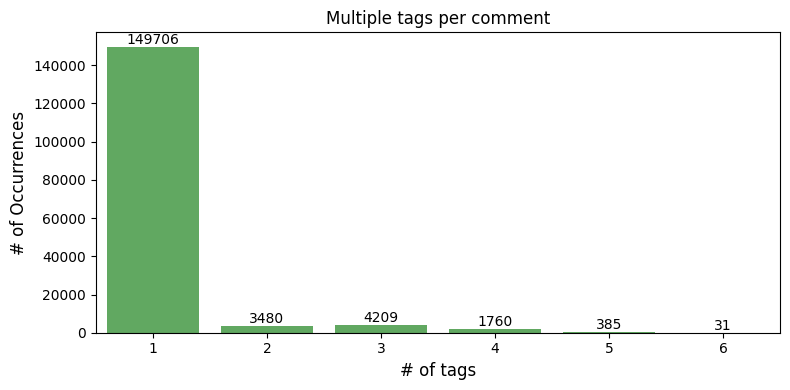

In [7]:
rowsums = comments_df.iloc[:, 2:].sum(axis=1)
x = rowsums.value_counts().sort_index()  # Sort by number of tags (optional for better visual)

color = sns.color_palette()

# Plot
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags', fontsize=12)

# Add text labels above bars
for rect, label in zip(ax.patches, x.values):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, int(label),
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Only ~10% of the total comments have some sort of toxicity in them. There are certain comments(20) that are marked as all of the above ###

### Let's look at the character length for the rows in the training data and record these ####


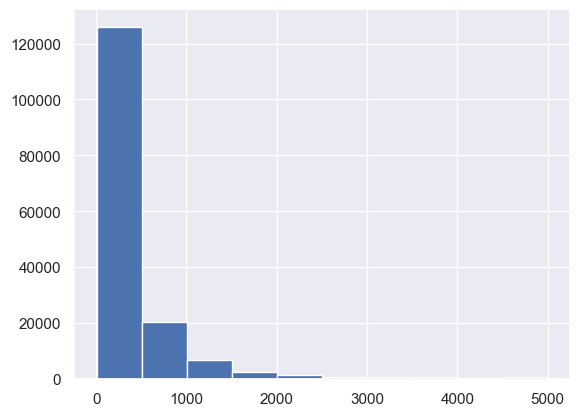

In [8]:
comments_df['char_length'] = comments_df['comment_text'].apply(lambda x: len(str(x)))

# look at the histogram plot for text length
sns.set()
comments_df['char_length'].hist()
plt.show()


#### Most of the text length are within 500 characters, with some up to 5,000 characters long ####

#### Which tags go together? ####

#### Now let's have a look at how often the tags occur together. A good indicator of that would be a correlation plot. ####

<Axes: >

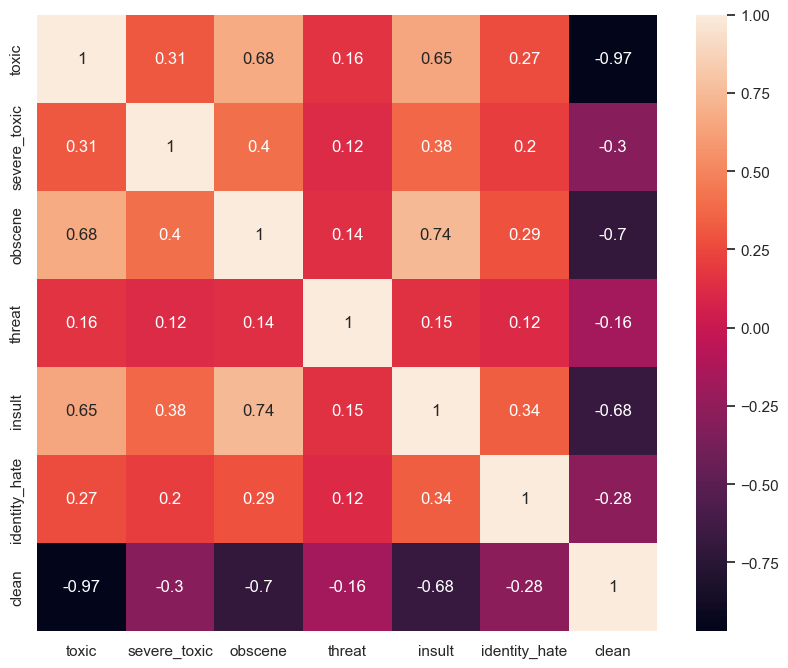

In [9]:
temp_df=comments_df.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

**The above plot indicates a pattern of co-occurance but Pandas's default Corr function which uses Pearson correlation does not apply here, since the variables invovled are Categorical (binary) variables.**

**So, to find a pattern between two categorical variables we can use other tools like**

**Confusion matrix/Crosstab**
**Cramer's V Statistic**
**Cramer's V stat is an extension of the chi-square test where the extent/strength of association is also measured**

In [10]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_max = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [11]:
#Crosstab
# Since technically a crosstab between all 6 classes is impossible to vizualize, lets take a 
# look at toxic with other tags
main_col="toxic"
corr_mats=[]
for other_col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[main_col], temp_df[other_col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting
out = out.style.apply(highlight_min,axis=0)
out

**The above table represents the Crosstab/ consufion matix of Toxic comments with the other classes.**

**Some interesting observations:**

**A Severe toxic comment is always toxic**
**Other classes seem to be a subset of toxic barring a few exceptions**

In [12]:
#https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix/39266194
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [13]:
#Checking for Toxic and Severe toxic for now
import pandas as pd
col1="toxic"
col2="severe_toxic"
confusion_matrix = pd.crosstab(temp_df[col1], temp_df[col2])
print("Confusion matrix between toxic and severe toxic:")
print(confusion_matrix)
new_corr=cramers_corrected_stat(confusion_matrix)
print("The correlation between Toxic and Severe toxic using Cramer's stat=",new_corr)

Confusion matrix between toxic and severe toxic:
severe_toxic       0     1
toxic                     
0             144277     0
1              13699  1595
The correlation between Toxic and Severe toxic using Cramer's stat= 0.30850290540548614


### Clean up the comment text ###

**1) Converts all characters to lowercase**

**2) Remove newline characters**

**3) Remove IP addresses**

**4) Remove usernames or bracketed metadata**

**5) Tokenization**

**6) Contraction Expansion**

**7) Lemmatization (verbs)**

**8) Stopword Removal**

In [15]:
import re
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize tokenizer, lemmatizer, and stopwords
tokenizer = WordPunctTokenizer()
lem = WordNetLemmatizer()
eng_stopwords = set(stopwords.words("english"))

# Contraction mapping (no duplicate keys)
APPO = {
    "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not",
    "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
    "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
    "i'd": "I would", "i'll": "I will", "i'm": "I am", "isn't": "is not", "it's": "it is",
    "it'll": "it will", "i've": "I have", "let's": "let us", "mightn't": "might not",
    "mustn't": "must not", "shan't": "shall not", "she'd": "she would", "she'll": "she will",
    "she's": "she is", "shouldn't": "should not", "that's": "that is", "there's": "there is",
    "they'd": "they would", "they'll": "they will", "they're": "they are", "they've": "they have",
    "we'd": "we would", "we're": "we are", "weren't": "were not", "we've": "we have",
    "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have",
    "where's": "where is", "who'd": "who would", "who'll": "who will", "who're": "who are",
    "who's": "who is", "who've": "who have", "won't": "will not", "wouldn't": "would not",
    "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have",
    "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"
}

def clean(comment):
    """
    This function receives a comment and returns a cleaned version
    """
    comment = comment.lower()
    comment = re.sub(r"\n", "", comment)
    comment = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", comment)  # remove IP addresses
    comment = re.sub(r"\[\[.*\]", "", comment)  # remove usernames/links in brackets
    
    words = tokenizer.tokenize(comment)
    words = [APPO[word] if word in APPO else word for word in words]
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in eng_stopwords]
    
    return " ".join(words)

# Apply to dataframe (assuming `comments_df` exists)
comments_df['comment_text'] = comments_df['comment_text'].map(clean)
comments_df.to_csv("cleaned_comments_df.csv", index=False)


### Wordclouds - Frequent words ###

🔍 Generating WordCloud for: toxic


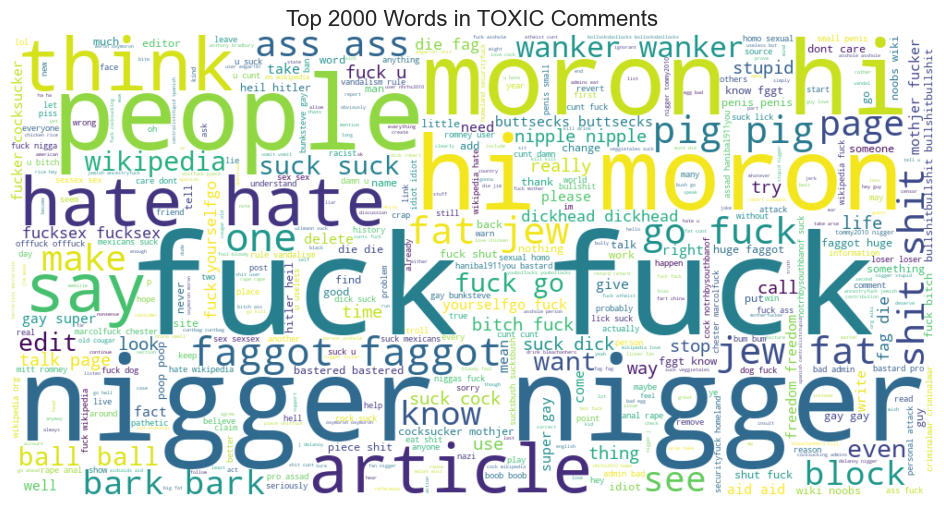

🔍 Generating WordCloud for: severe_toxic


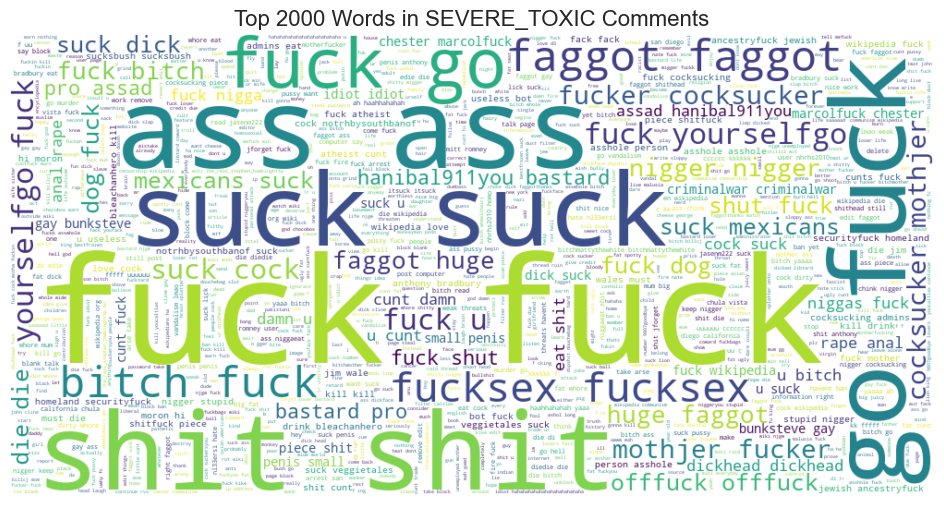

🔍 Generating WordCloud for: obscene


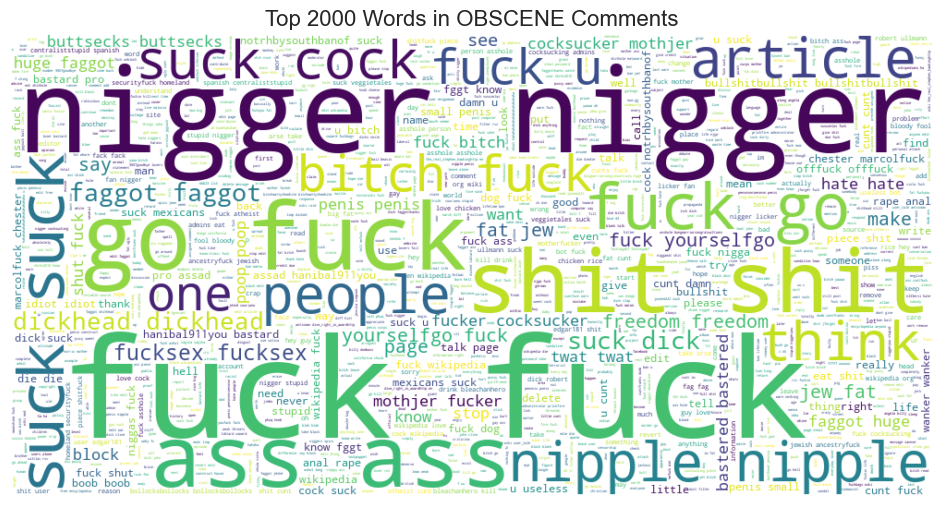

🔍 Generating WordCloud for: threat


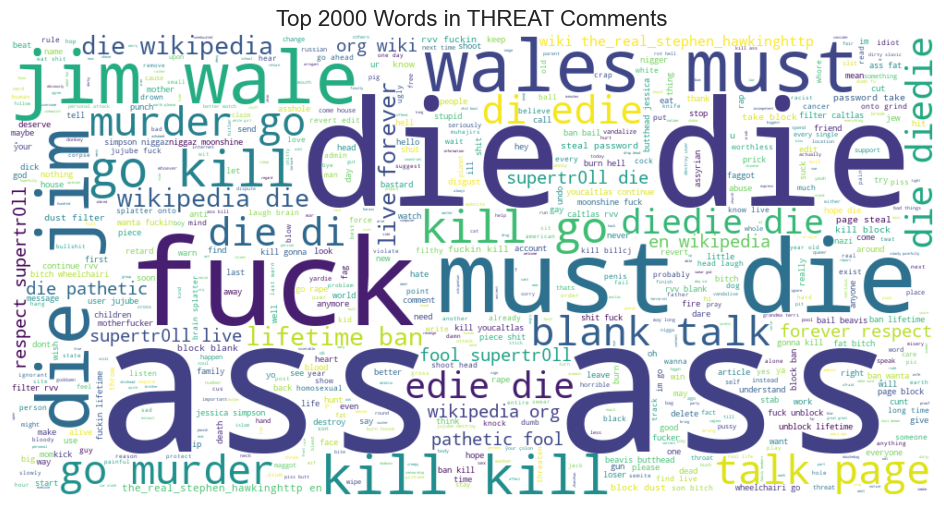

🔍 Generating WordCloud for: insult


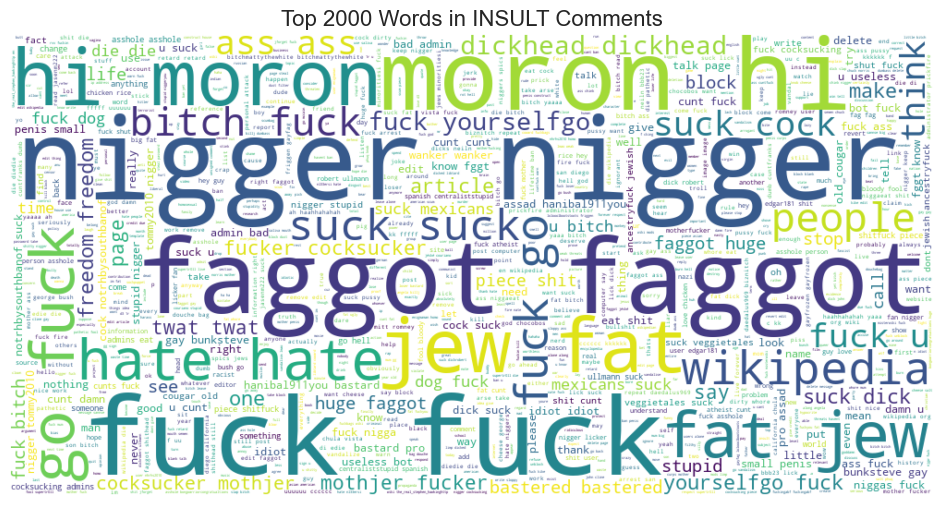

🔍 Generating WordCloud for: identity_hate


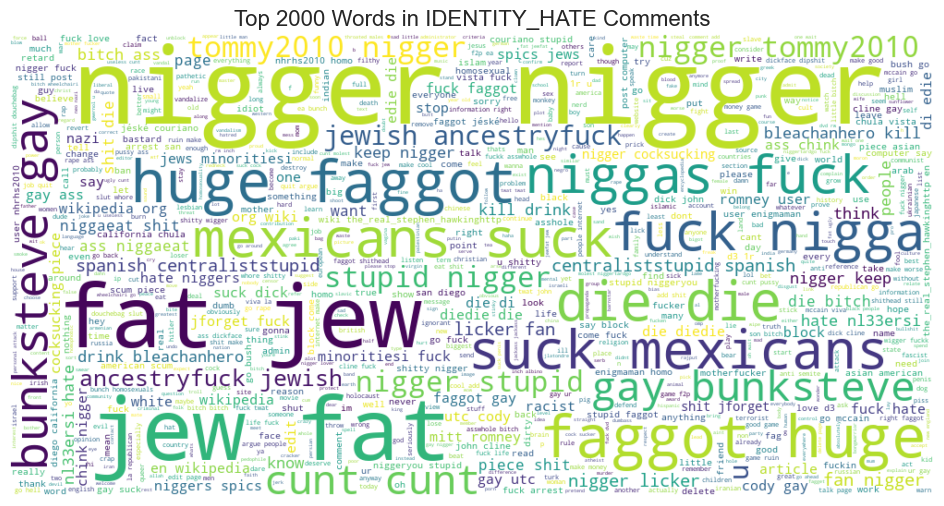


 Generating WordCloud for: CLEAN comments


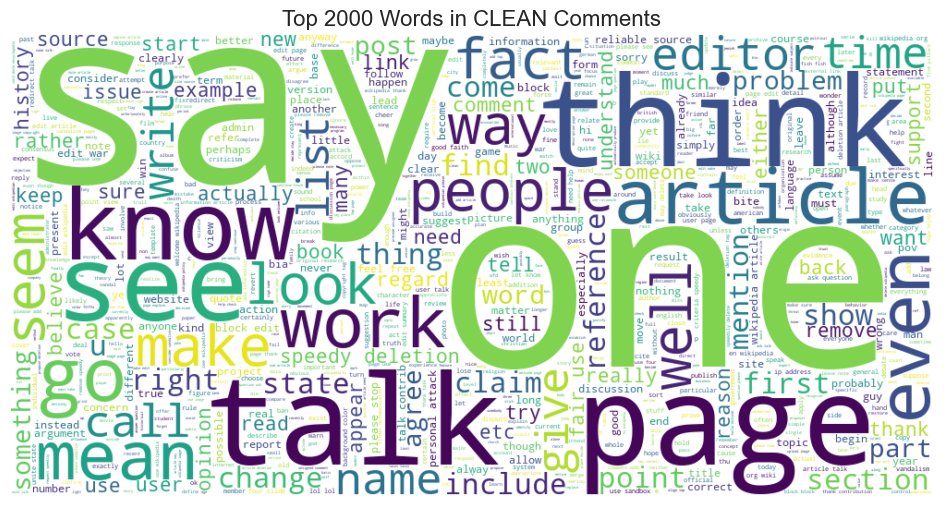

In [16]:
# Labels in your multi-label dataset
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Preprocessing Function
def preprocess_text(text_series):
    text_series = text_series.astype(str).str.lower()
    text_series = text_series.apply(lambda x: re.sub(r'[^\w\s]', '', x))  # remove punctuation
    return ' '.join(text_series)

# WordCloud Generator
def generate_wordcloud(text, title):
    wordcloud = WordCloud(
        width=1000,
        height=500,
        max_words=2000,
        background_color='white',
        stopwords=STOPWORDS
    ).generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# WordCloud for each toxic label
for label in labels:
    print(f"🔍 Generating WordCloud for: {label}")
    label_comments = comments_df[comments_df[label] == 1]['comment_text']
    
    if not label_comments.empty:
        text = preprocess_text(label_comments)
        generate_wordcloud(text, f"Top 2000 Words in {label.upper()} Comments")
    else:
        print(f"No. of comments found for label: {label}")

# WordCloud for CLEAN comments (clean == True)
print(f"\n Generating WordCloud for: CLEAN comments")
clean_comments = comments_df[comments_df['clean'] == True]['comment_text']

if not clean_comments.empty:
    clean_text = preprocess_text(clean_comments)
    generate_wordcloud(clean_text, "Top 2000 Words in CLEAN Comments")
else:
    print("No. of clean comments found.")
